## Text Summarization with an Encoder-Decoder RNN with Fastai package

In [1]:
import datetime


In [2]:
datetime.datetime.now().strftime('preds_%Y%m%d_%H%M%S')

'preds_20200504_200247'

In [2]:
from fastai.text import *

In [3]:
#path = Config().data_path()

DATA_PATH = 'abs_text_summa/data/'
SAMPLE_DATA_PATH = f'{DATA_PATH}'
TEMP_DATA_PATH = f'{DATA_PATH}/temp'
glove_filename=f'{DATA_PATH}glove.6B.100d.txt'
model_path = 'abs_text_summa/models/'

#### Load the News Summary dataset

In [38]:
#Load from the Gloogle Cloud Storage bucket
!gsutil cp gs://mlend_bucket/data/news_summary/news_summary_more.csv $DATA_PATH

Copying gs://mlend_bucket/data/news_summary/news_summary_more.csv...
- [1 files][ 39.5 MiB/ 39.5 MiB]                                                
Operation completed over 1 objects/39.5 MiB.                                     


In [4]:
df = pd.read_csv(SAMPLE_DATA_PATH+'news_summary_more.csv')
df.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


To make it simple, we lowercase everything.

In [5]:
df['text'] = df['text'].apply(lambda x:x.lower())
df['headlines'] = df['headlines'].apply(lambda x:x.lower())

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


The first thing is that we will need to collate inputs and targets in a batch: they have different lengths so we need to add padding to make the sequence length the same

In [6]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

Then we create a special DataBunch that uses this collate function.

In [7]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)


And a subclass of TextList that will use this DataBunch class in the call .databunch and will use TextList to label (since our targets are other texts).

In [8]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

Thats all we need to use the data block API!

In [9]:
src = Seq2SeqTextList.from_df(df, path = TEMP_DATA_PATH, cols='text').split_by_rand_pct(seed=42).label_from_df(cols='headlines', label_cls=TextList)

Lets analyze and search the max length of the text sequences to set the max_length of an output
We remove the items where one of the target is more than 46 tokens long.

In [10]:
np.percentile([len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items], 90)

76.0

In [11]:
np.percentile([len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items], 90)

14.0

In [12]:
max_length=76
src = src.filter_by_func(lambda x,y: len(x) > max_length or len(y) > max_length)

In [13]:
len(src.train) + len(src.valid)

89088

In [15]:
data = src.databunch()
data

Seq2SeqDataBunch;

Train: LabelList (71238 items)
x: Seq2SeqTextList
xxbos saurav kant , an alumnus of upgrad and iiit - b 's pg program in machine learning and artificial intelligence , was a sr systems engineer at infosys with almost 5 years of work experience . the program and upgrad 's 360-degree career support helped him transition to a data scientist at tech mahindra with 90 % salary hike . upgrad 's online power learning has powered 3 xxunk careers .,xxbos kunal shah 's credit card bill payment platform , cred , gave users a chance to win free food from swiggy for one year . pranav kaushik , a delhi techie , bagged this reward after spending 2000 cred coins . users get one cred coin per rupee of bill paid , which can be used to avail rewards from brands like ixigo , bookmyshow , ubereats , xxunk and more .,xxbos new zealand defeated india by 8 wickets in the fourth odi at hamilton on thursday to win their first match of the five - match odi series . india lost an international m

In [16]:
data.show_batch()

text,target
"xxbos trolling amitabh bachchan over his tweet asking twitter to increase his number of followers , a user wrote , "" sir lagta hai twitter ne gst xxunk liya . "" another tweet read , "" such jealousy because shah rukh has more followers . "" referring to big b 's alleged involvement in the panama papers scam , a user tweeted , "" sir panama papers xxunk xxunk tab",xxbos big b trolled for asking twitter to increase his followers
"xxbos swedish youtuber pewdiepie has uploaded a video which ended with a disclaimer saying , "" do n't be like ekta kapoor and go on a twitter rant when it is completely unrelated to you . "" he titled the video , "" she is angry because i made fun of her "" . pewdiepie spelled ekta 's name wrong in the beginning , saying , "" xxunk kapoor here",xxbos do n't be like ekta kapoor : swedish youtuber pewdiepie
"xxbos bihar cm nitish kumar - led jd(u ) will continue being a part of nda alliance for the 2019 lok sabha elections , jd(u ) general secretary sanjay kumar jha announced after the party 's national executive meeting on sunday . "" it will be decided later as to which party will contest how many seats , "" he added . last year , kumar exited the ' mahagathbandhan",xxbos jd(u ) to be part of nda alliance for 2019 lok sabha polls
"xxbos after bangladesh registered an innings victory against windies in tests on sunday , captain shakib al hasan said , "" this is the first time we enforced ... follow - on in more than 100 tests in 18 years , which is definitely something special . "" "" we have n't done this against smaller teams , so to do it against a higher - ranked side is an",xxbos to enforce follow - on after 100 tests in 18 years is special : shakib
"xxbos with business sentiment at its "" weakest "" in four years , india has slipped to the 6th position globally in business optimism index for the first quarter of this year , according to a survey by grant thornton . however , business optimism is at an "" all - time high "" globally , it added . the top five countries are austria , finland , indonesia ,",xxbos india slips to 6th spot in business xxunk index : survey


### Create our Model
#### Pretrained embeddings
You will need to download the word embeddings (crawl vectors) from the fastText docs. FastText has pre-trained word vectors for 157 languages, trained on Common Crawl and Wikipedia. These models were trained using CBOW.

If you need a refresher on word embeddings, you can check out my gentle intro in this word embedding workshop with accompanying github repo.

More reading on CBOW (Continuous Bag of Words vs. Skip-grams):

fastText tutorial
StackOverflow
To install fastText:

$ git clone https://github.com/facebookresearch/fastText.git
$ cd fastText
$ pip install 

In [26]:
!pwd

/home/jupyter


In [29]:
%%bash
gsutil cp gs://mlend_bucket/embeddings/glove.6B.100d.txt abs_text_summa/data

Copying gs://mlend_bucket/embeddings/glove.6B.100d.txt...
\ [1 files][331.0 MiB/331.0 MiB]                                                
Operation completed over 1 objects/331.0 MiB.                                    


Create a Class that load the Glove embeddings and generates the word2vec (mapping words to embedding vector). The Class defines a function to transforme a list of sentences to a list of embeddings vectors

In [17]:
class GloveVectorizer:
  def __init__(self, embedding_file):
    # load in pre-trained word vectors
    print('Loading word vectors...')
    word2vec = {}
    embedding = []
    idx2word = []
    with open(embedding_file) as f:
      # is just a space-separated text file in the format:
      # word vec[0] vec[1] vec[2] ...
      for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
        embedding.append(vec)
        idx2word.append(word)
    print('Found %s word vectors.' % len(word2vec))

    # save for later
    self.word2vec = word2vec
    self.embedding = np.array(embedding)
    self.word2idx = {v:k for k,v in enumerate(idx2word)}
    self.V, self.D = self.embedding.shape

  def fit(self, data):
    pass

  def transform(self, data):
    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.lower().split()
      vecs = []
      for word in tokens:
        if word in self.word2vec:
          vec = self.word2vec[word]
          vecs.append(vec)
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    #print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X

  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)


In [18]:
#Load the Glove embeddings
vectorizer = GloveVectorizer(glove_filename)

Loading word vectors...
Found 400000 word vectors.


In [19]:
print('Emebdding size: ',vectorizer.embedding.shape[1])

Emebdding size:  100


In [20]:
def create_emb(vecs, itos, em_sz=100, mult=1.):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    #vec_dic = {w:vecs.word2vec[w] for w in vecs.get_words()}
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = tensor(vecs.word2vec[w])
        except: miss.append(w)
    return emb

In [21]:
emb_enc = create_emb(vectorizer, data.x.vocab.itos, vectorizer.embedding.shape[1])
emb_dec = create_emb(vectorizer, data.y.vocab.itos,vectorizer.embedding.shape[1])

In [22]:
emb_enc.weight.size(), emb_dec.weight.size()

(torch.Size([38472, 100]), torch.Size([16736, 100]))

Save the encoder and decoder embeddings

In [23]:
torch.save(emb_enc, model_path+'enc_emb.pth')
torch.save(emb_dec, model_path+'dec_emb.pth')

In [24]:
emb_enc = torch.load(model_path+'enc_emb.pth')
emb_dec = torch.load(model_path+'dec_emb.pth')

### Our Model
Review Question: What are the two types of numbers in deep learning?

#### Encoders & Decoders
The model in itself consists in an encoder and a decoder

The encoder is a recurrent neural net and we feed it our input sentence, producing an output (that we discard for now) and a hidden state. A hidden state is the activations that come out of an RNN.

That hidden state is then given to the decoder (an other RNN) which uses it in conjunction with the outputs it predicts to get produce the translation. We loop until the decoder produces a padding token (or at 30 iterations to make sure it's not an infinite loop at the beginning of training).

We will use a GRU for our encoder and a separate GRU for our decoder. Other options are to use LSTMs or QRNNs (see here). GRUs, LSTMs, and QRNNs all solve the problem of how RNNs can lack long-term memory.

Links:

Illustrated Guide to LSTM’s and GRU’s: A step by step explanation
https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

fast.ai implementation of seq2seq with QRNNs
https://github.com/fastai/fastai_docs/blob/master/dev_course/dl2/translation.ipynb

In [49]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, 
                    nh, out_sl, 
                    nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return h, outp
        
    def forward(self, inp):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            dec_inp = outp.max(1)[1]
            res.append(outp)
            if (dec_inp==self.pad_idx).all(): break
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)

In [50]:
xb,yb = next(iter(data.valid_dl))
print(xb.shape, yb.shape)

torch.Size([64, 50]) torch.Size([64, 19])


#### Some model oparameters

In [25]:
hidden_size=50
output_length=max_length

In [27]:
#hidden=50
rnn = Seq2SeqRNN(emb_enc, emb_dec, hidden_size, output_length)

NameError: name 'Seq2SeqRNN' is not defined

In [52]:
rnn

Seq2SeqRNN(
  (emb_enc): Embedding(10832, 100, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15, inplace=False)
  (gru_enc): GRU(100, 50, num_layers=2, batch_first=True, dropout=0.25)
  (out_enc): Linear(in_features=50, out_features=100, bias=False)
  (emb_dec): Embedding(5912, 100, padding_idx=1)
  (gru_dec): GRU(100, 100, num_layers=2, batch_first=True, dropout=0.1)
  (out_drop): Dropout(p=0.35, inplace=False)
  (out): Linear(in_features=100, out_features=5912, bias=True)
)

In [53]:
print(len(xb[0]))
h = rnn.encoder(64, xb.cpu())
print(h.size())

50
torch.Size([2, 64, 100])


The loss pads output and target so that they are of the same size before using the usual flattened version of cross entropy. We do the same for accuracy.

In [26]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

## Train our model

In [56]:
learn = Learner(data, rnn, loss_func=seq2seq_loss)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


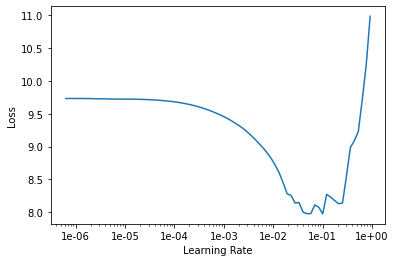

In [57]:
learn.lr_find()
learn.recorder.plot()

In [58]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,time
0,6.530246,6.913758,01:58
1,6.278243,6.326666,01:25
2,5.880736,6.058234,01:26


Let's free up some RAM

In [27]:
del vectorizer

So how good is our model? Let's see a few predictions.

In [28]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x,y,z in zip(xb,yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [61]:
inputs, targets, outputs = get_predictions(learn)

In [62]:
inputs[700], targets[700], outputs[700]

(Text xxbos a truck bomb exploded outside a u.s . air force housing area near the eastern saudi arabian city of xxunk , killing at least # # americans and injuring more than # # # , u.s . officials said .,
 Text xxbos precede xxunk at least # # killed in military building blast in saudi arabia,
 Text xxbos car bomb in in in in in)

As loss is not very interpretable, let's also look at the accuracy. Again, we will add padding so that the output and target are of the same length.

In [29]:

def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

### Training with metrics

In [64]:
learn = Learner(data, rnn, loss_func=seq2seq_loss, metrics=[seq2seq_acc])

epoch,train_loss,valid_loss,seq2seq_acc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


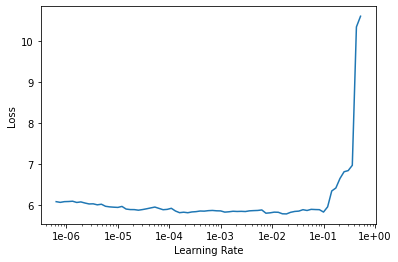

In [65]:
learn.lr_find()
learn.recorder.plot()

In [66]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,seq2seq_acc,time
0,5.979742,6.137157,0.187140,01:27
1,5.640651,6.034876,0.193152,01:27
2,5.321558,5.487740,0.251230,01:29


In [67]:
inputs, targets, outputs = get_predictions(learn)

In [68]:
inputs[700], targets[700], outputs[700]

(Text xxbos a truck bomb exploded outside a u.s . air force housing area near the eastern saudi arabian city of xxunk , killing at least # # americans and injuring more than # # # , u.s . officials said .,
 Text xxbos precede xxunk at least # # killed in military building blast in saudi arabia,
 Text xxbos bomb bomb # # # # in in in in)

### Teacher forcing
One way to help training is to help the decoder by feeding it the real targets instead of its predictions (if it starts with wrong words, it's very unlikely to give us the right translation). We do that all the time at the beginning, then progressively reduce the amount of teacher forcing.

In [30]:
class TeacherForcing(LearnerCallback):
    
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - epoch/self.end_epoch

We will add the following code to our forward method:

    if (targ is not None) and (random.random()<self.pr_force):
        if i>=targ.shape[1]: break
        dec_inp = targ[:,i]
Additionally, forward will take an additional argument of target.

In [70]:
class Seq2SeqRNN_tf(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 0.
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return h, outp
            
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            res.append(outp)
            dec_inp = outp.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)

    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)

In [71]:
rnn_tf = Seq2SeqRNN_tf(emb_enc, emb_dec, 50, 50)

learn = Learner(data, rnn_tf, loss_func=seq2seq_loss, metrics=[seq2seq_acc],
               callback_fns=partial(TeacherForcing, end_epoch=3))

epoch,train_loss,valid_loss,seq2seq_acc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


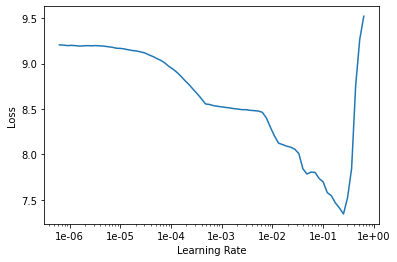

In [73]:
learn.lr_find()
learn.recorder.plot()

In [74]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,seq2seq_acc,time
0,4.727007,1.828480,0.693504,01:47
1,4.418235,4.412993,0.410100,01:36
2,5.289579,5.318548,0.285574,01:33


In [75]:
inputs, targets, outputs = get_predictions(learn)
print(inputs[700],targets[700],outputs[700])

xxbos a truck bomb exploded outside a u.s . air force housing area near the eastern saudi arabian city of xxunk , killing at least # # americans and injuring more than # # # , u.s . officials said . xxbos precede xxunk at least # # killed in military building blast in saudi arabia xxbos car bomb kills # # # # # #


## Seq2Seq Translation with Attention
Attention is a technique that uses the output of our encoder: instead of discarding it entirely, we use it with our hidden state to pay attention to specific words in the input sentence for the predictions in the output sentence. Specifically, we compute attention weights, then add to the input of the decoder the linear combination of the output of the encoder, with those attention weights.

A nice illustration of attention comes from [this blog post](http://jalammar.github.io/illustrated-transformer/) by Jay Alammar (visualization originally from Tensor2Tensor notebook):

A second things that might help is to use a **bidirectional model for the encoder**. We set the bidrectional parameter to True for our GRU encoder, and double the number of inputs to the linear output layer of the encoder.

Also, we now need to set our hidden state:

hid = hid.view(2,self.n_layers, bs, self.n_hid).permute(1,2,0,3).contiguous()
hid = self.out_enc(self.hid_dp(hid).view(self.n_layers, bs, 2*self.n_hid))


In [31]:
class Seq2SeqRNN_attn(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl,self.pr_force = nl,nh,out_sl,1
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.emb_enc,self.emb_dec = emb_enc,emb_dec
        self.emb_sz_enc,self.emb_sz_dec = emb_enc.embedding_dim,emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.emb_sz_enc, nh, num_layers=nl, dropout=0.25, 
                              batch_first=True, bidirectional=True)
        self.out_enc = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
        
        self.gru_dec = nn.GRU(self.emb_sz_dec + 2*nh, self.emb_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.emb_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
        self.enc_att = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
        self.hid_att = nn.Linear(self.emb_sz_dec, self.emb_sz_dec)
        self.V =  self.init_param(self.emb_sz_dec)
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, hid = self.gru_enc(emb, 2*h)
        
        pre_hid = hid.view(2, self.nl, bs, self.nh).permute(1,2,0,3).contiguous()
        pre_hid = pre_hid.view(self.nl, bs, 2*self.nh)
        hid = self.out_enc(pre_hid)
        return hid,enc_out
    
    def decoder(self, dec_inp, hid, enc_att, enc_out):
        hid_att = self.hid_att(hid[-1])
        # we have put enc_out and hid through linear layers
        u = torch.tanh(enc_att + hid_att[:,None])
        # we want to learn the importance of each time step
        attn_wgts = F.softmax(u @ self.V, 1)
        # weighted average of enc_out (which is the output at every time step)
        ctx = (attn_wgts[...,None] * enc_out).sum(1)
        emb = self.emb_dec(dec_inp)
        # concatenate decoder embedding with context (we could have just
        # used the hidden state that came out of the decoder, if we weren't
        # using attention)
        outp, hid = self.gru_dec(torch.cat([emb, ctx], 1)[:,None], hid)
        outp = self.out(self.out_drop(outp[:,0]))
        return hid, outp
        
    def show(self, nm,v):
        if False: print(f"{nm}={v[nm].shape}")
        
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        hid,enc_out = self.encoder(bs, inp)
#        self.show("hid",vars())
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        enc_att = self.enc_att(enc_out)
        
        res = []
        for i in range(self.out_sl):
            hid, outp = self.decoder(dec_inp, hid, enc_att, enc_out)
            res.append(outp)
            dec_inp = outp.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)

    def initHidden(self, bs): return one_param(self).new_zeros(2*self.nl, bs, self.nh)
    def init_param(self, *sz): return nn.Parameter(torch.randn(sz)/math.sqrt(sz[0]))

hid=torch.Size([2, 64, 300])
dec_inp=torch.Size([64])
enc_att=torch.Size([64, 30, 300])
hid_att=torch.Size([64, 300])
u=torch.Size([64, 30, 300])
attn_wgts=torch.Size([64, 30])
enc_out=torch.Size([64, 30, 512])
ctx=torch.Size([64, 512])
emb=torch.Size([64, 300])

In [32]:
model = Seq2SeqRNN_attn(emb_enc, emb_dec, hidden_size, output_length)
learn = Learner(data, model, loss_func=seq2seq_loss, metrics=[seq2seq_acc],
                callback_fns=partial(TeacherForcing, end_epoch=3))

In [33]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,seq2seq_acc,time


Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._h

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [ ]:
learn.fit_one_cycle(3, 3e-2)

epoch,train_loss,valid_loss,seq2seq_acc,time
0,7.216854,4.807383,0.079253,29:12


In [36]:
inputs, targets, outputs = get_predictions(learn)

In [37]:
inputs[700], targets[700], outputs[700]

(Text xxbos sachin tendulkar shared an old photograph of himself with his father ramesh tendulkar , on the occasion of father 's day . " you held my hand ... showed me the world and gave me the best advice . happy father 's day ! " sachin captioned the photograph . notably , sachin had scored a century against kenya in the 1999 world cup , a few days after his father passed away .,
 Text xxbos sachin shares old photo with his dad on father 's day,
 Text xxbos i 's 's 's 's 's 's 's 's 's 's)